### Strategy description

https://tradingstrategyguides.com/swing-trading-strategies-that-work/

It's based on classic technical indicator called "Bollinger Bands". It's construced as:
- central moving average (MA), which is a simple moving average.
- two other moving averages at a distance of +-2 standard dev. away from the central MA

There are following steps:
**Step 1**: Wait for the price to touch the Upper Bollinger Band. It (in theory) means that price is price moving into 
overbought territory. That is - price is relatively too high for given stock and will probably go down.

**Step 2**: Wait for the price to Break below the Middle Bollinger Bands. Such a move acts as confirmation of the 
shift in market sentiment. In other words - investors realized that stock is overbought and started seeling
(hence price is going down).

Important Note: the "breakout" of the central MA should be so called "Big Bold Breakout Candle". That is
closing price is near the Low Range of the Candlestick. One should sell at the closing price of the Breakout Candle.

**Step 3**: This "Breakout Candle" is meant to confirm that there are real sellers, that is: there is an assumption that such a strong move down indicates actual changed sentiment of sellers rather that just its the "natural" fluctation 
of the price.

**Step 4**: Set-up "Protective Stop Loss" above the Breakout Candle
As a stop loss high of the entry candle is taken. Rationalities behind it is that during entry move one assumes 
candle as representation of real market sentiment and sellers. If high of this candle is "broken" that is
clear sign that in this case there was no real sellers sentiment shift.

**Step 5**: Take Profit once we break and close back above the middle Bollinger Bands (central MA)

THAT WAS SHORT TRADE EXAMPLE. FOR LONG TRADES THERE ARE SAME STEPS BUT IN REVERSED ORDER

### My personal thoughts:
- It would be nice to have some sort of expected range of the move. That is - one is setting up stop loss which is 
fine, but at the same time there is no expected range of the move in preferable direction. That makes calculating
reward-to-risk ratio imposibble.
- If one have multiple trades to choose (and properly diversify portfolio) then given strategy gives no clues about
which trade choose. R2R ratio would be helpfull.
- That problem occures not only when we have couple of trades to choose in the same day. One can "loose" future trade
by choosing the one today - which in reality one is not aware of having small R2RR.
- Having method to estimate R2RR and uses it as an additional filter for trades could be good enhacemnet for that
strategy.

"Big Bold Candle" is actually really unclear. In the article it is mentioned that is should have (for short) 
"closing price is near the Low Range of the Candlestic". The thing is that "Low Range" is the thin line below the 
body - it's also called "wick" or "shadow". But in what sense it's big? Closing price may be  near lowest price but 
the whole price range (from high to low - indication of volatility) may be really "small"...
I could not find any canlde formation actually called "big bold...". I think authours could refer to 2 formations
called "Big Black Candle" and "Big White Candle". Thoe are candles with long bodies. 

Big Black Candle - Has an unusually long black body with a wide range between high and low. Prices open near the
high and close near the low. Considered a bearish pattern.

Big White Candle - Has an unusually long white body with a wide range between high and low of the day. Prices open 
near the low and close near the high. Considered a bullish pattern.

The problem with those definitions is - what it means "unusually long (...) body"? How to quantify that? I could
not find anything more specific than adjectives like "long", "big" etc...

I'd say it should be parametrized somewhow... Or taken from distibution of ranges from the past... I imagine 
that "long" candles may be for stocks quite "normal" where for the others they are super rare. 

As a proxy distribution I can take average range and standard deviation in last X days. It may be the same period
I'm taking for moving average or the other. Then I can see how many standard deviations from average given candle's
range is. If it's above certain threshold - consider it as "big".

In [34]:
# built-in
from itertools import islice
import sys
sys.path.insert(0, '/Users/slaw/osobiste/trading')

# 3rd party
import numpy as np
from mpl_finance import candlestick_ohlc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import scipy.stats as stats

# custom
import gpw_data
import strategies.helpers as helpers
import backtester
import position_size
import results

# to allow zoom plots
%matplotlib notebook  

In [17]:
def generate_signals(df, ma_type='simple', time_window=20, no_std=2):
    df = df.copy()
    
    # 1) bollinger_bands
    df = helpers.create_bollinger_bands(symbol, ma_type=ma_type, time_window=time_window, no_std=no_std)
    
    # 2) find breakout candles ("Big Bold Candels" from the strategy description)
    # get lenght of clandles body, it's average and std dev
    df.loc[:, 'candle_range'] = abs(df['close'] - df['open'])
    df.loc[:, 'candle_range_avg'] = df['candle_range'].rolling(window=time_window).mean()
    df.loc[:, 'candle_range_std'] = df['candle_range'].rolling(window=time_window).std()
    # identify "long" candles
    df.loc[:, 'is_long'] = abs(df['candle_range_avg'] - df['candle_range']) > no_std*df['candle_range_std']
    
    # 3) # Overbought and oversold regimes
    upper_diff_idx0 = abs(df['upper_ma'].iloc[0] - df['close'].iloc[0])
    lower_diff_idx0 = abs(df['lower_ma'].iloc[0] - df['close'].iloc[0])
    if upper_diff_idx0 >= lower_diff_idx0:
        first_period = 'L'
    elif upper_diff_idx0 < lower_diff_idx0:
        first_period = 'U'
    df.loc[:, 'previous_period'] = ''
    df.at[df.index[0], 'previous_period'] = first_period
    df.replace('', np.nan, inplace=True)
    
    # df.loc[:, 'previous_period'] = np.where(df['close'] <= df['lower_ma'], 'L', df['previous_period'])
    # df.loc[:, 'previous_period'] = np.where(df['close'] >= df['upper_ma'], 'U', df['previous_period'])
    
    df.loc[:, 'previous_period'] = np.where(
        ((df['close'] <= df['lower_ma']) | (df['open'] <= df['lower_ma'])),
        'L', df['previous_period']
    )
    df.loc[:, 'previous_period'] = np.where(
        ((df['close'] >= df['upper_ma']) | (df['open'] >= df['upper_ma'])),
        'U', df['previous_period']
    )
    
    
    df['previous_period'].fillna(method='ffill', inplace=True)
    
    # 4) *for debuging* get first/last dates for Overbought/oversold periods
    overbought = []
    oversold = []
    prev = first_period
    prev_idx_int = 0
    idx_int = 1
    for idx, row in islice(df.iterrows(), 1, None):
        cur = row['previous_period']
        if prev == 'U' and cur == 'L':
            overbought.append((df.index[prev_idx_int], df.index[idx_int-1]))
            prev = cur
            prev_idx_int = idx_int
        elif prev == 'L' and cur == 'U':
            oversold.append((df.index[prev_idx_int], df.index[idx_int-1]))
            prev = cur
            prev_idx_int = idx_int
        if prev == cur:
            idx_int += 1
            continue
        idx_int += 1
        
    # 5) GENERATE ENTRY AND EXIT SIGNALS
    df.loc[:, 'entry_long'] = 0
    df.loc[:, 'entry_short'] = 0
    df.loc[:, 'exit_long'] = 0
    df.loc[:, 'exit_short'] = 0
    df.loc[:, 'stop_loss'] = np.nan
    # helper tracking variable to correctly set up things
    _long_position = 0
    _short_position = 0
    _long_above_cma = 0
    _short_below_cma = 0
    _stop_loss = 0
    for i, row in df.iterrows():
        # exits
        exit_long_signal = (row['close'] <= row['central_ma']) and _long_above_cma == 1
        exit_short_signal = (row['close'] >= row['central_ma']) and _short_below_cma == 1
        if exit_long_signal and _long_position == 1:
            df.at[i,'exit_long'] = 1
            _long_position = 0
            _long_above_cma = 0
        elif exit_short_signal and _short_position == 1:
            df.at[i,'exit_short'] = 1
            _short_position = 0
            _short_below_cma = 0
            
        # entries
        entry_long_signal = (row['is_long'] == True) and (row['close'] > row['open']) and (row['previous_period'] == 'L')
        entry_short_signal = (row['is_long'] == True) and (row['close'] < row['open']) and (row['previous_period'] == 'U')
        
        if (entry_long_signal == True) and (_long_position == 0) and (_short_position == 0):
            df.at[i,'entry_long'] = 1
            _long_position = 1
            _stop_loss = row['low']
        elif (entry_short_signal == True) and (_long_position == 0) and (_short_position == 0):
            df.at[i,'entry_short'] = 1
            _short_position = 1
            _stop_loss = row['high']
        
        # set up crossing middle central moving average
        if _long_position == 1 and row['open'] > row['central_ma']:
            _long_above_cma = 1
        elif _short_position == 1 and row['open'] < row['central_ma']:
            _short_below_cma = 1
        # roll over stop loss
        if _long_position == 1 or _short_position == 1:
            df.at[i,'stop_loss'] = _stop_loss
            
    # 6) *for debuging* get long and short trades periods
    long_periods, short_periods = helpers.gather_entry_exist_signals_dates(df)
    
    return {
        'df': df,
        'long_periods': long_periods,
        'short_periods': short_periods,
        'overbought_periods': overbought,
        'oversold_periods': oversold,
    }
    

In [38]:
symbol_key = 'ENEA'
gpwdata = gpw_data.GPWData(pricing_data_path='../pricing_data')
wig_20_stocks = gpwdata.load(index='WIG20')
symbol_data = wig_20_stocks[symbol_key]

In [39]:
df_with_signals = generate_signals(
    symbol_data,
    ma_type='simple',
    time_window=10,
    no_std=2
)
# print(df_with_signals['df'].head(28))

<IPython.core.display.Javascript object>


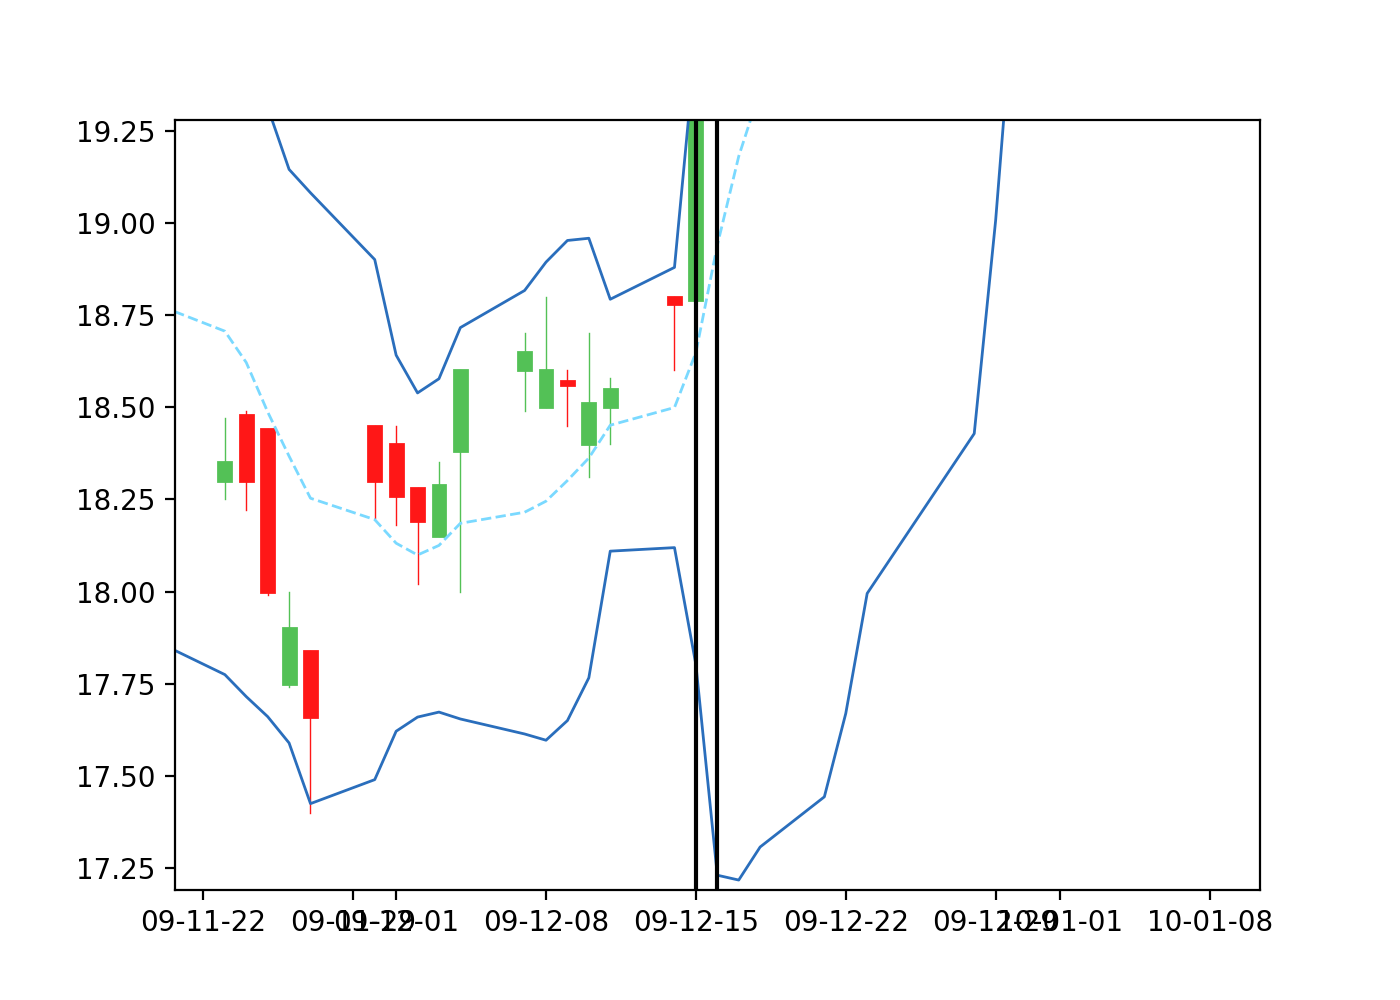

In [35]:
def plot_strategy_signals(
    df=None, ohlc=False, bands=True, close=False, candles=True, long_periods=None, short_periods=None,
    overbought_periods=None, oversold_periods=None
):
    df = df.copy()
    
    fig, ax = plt.subplots(figsize=(7,5))
    
    # candle chart
    if ohlc == True:
        df.loc[:, 'date'] = pd.to_datetime(df.index)
        df.loc[:, 'date'] = df['date'].apply(mdates.date2num)
        df_for_candle = df[['date', 'open', 'high', 'low', 'close']]
        ax.xaxis_date()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
        candlestick_ohlc(ax, df_for_candle.values, width=.6, colorup='#53c156', colordown='#ff1717')

    # bands, close price and candles
    if bands == True:
        ax.plot(df['central_ma'], color='#7ad9ff', linestyle='--', linewidth=1)
        ax.plot(df['lower_ma'], color='#2a6ebc', linestyle='-', linewidth=1)
        ax.plot(df['upper_ma'], color='#2a6ebc', linestyle='-', linewidth=1)
    if close == True:
        ax.plot(df['close'], color='black', linestyle='-', linewidth=1)
    if candles == True:
        long_candles = df[df['is_long']].index.tolist()
        for c in long_candles:
            ax.axvline(c, color='black', linestyle='-')
    
    # long/short trades periods
    if isinstance(long_periods, list):
        for lp in long_periods:
            ax.axvspan(lp[0], lp[1], alpha=0.5, color='green')
    if isinstance(short_periods, list):
        for sp in short_periods:
            ax.axvspan(sp[0], sp[1], alpha=0.5, color='red')
    
    # overbough and oversold
    if isinstance(overbought_periods, list):
        for obp in overbought_periods:
            ax.axvspan(obp[0], obp[1], alpha=0.5, color='yellow')
    if isinstance(oversold_periods, list):
        for osp in oversold_periods:
            ax.axvspan(osp[0], osp[1], alpha=0.5, color='blue')
    
    plt.show()


plot_strategy_signals(
    df = df_with_signals['df'],
    ohlc = True,
    # candles = False,
    long_periods = df_with_signals['long_periods'],
    short_periods = df_with_signals['short_periods'],
    # overbought_periods = df_with_signals['overbought_periods'],
    # oversold_periods = df_with_signals['oversold_periods'],
)

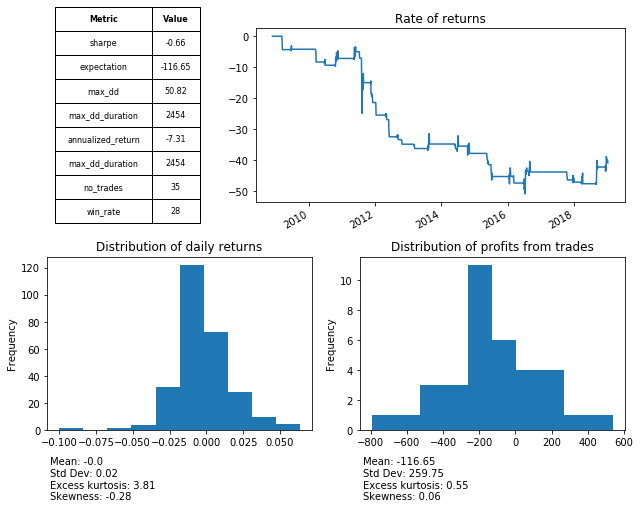

In [21]:
# Test run of the strategy
initial_signals = {symbol_key: df_with_signals['df']}
position_sizer = position_size.MaxFirstEncountered()
tester = backtester.Backtester(initial_signals, position_sizer=position_sizer, )
tester1_results, tester1_trades = tester.run()

# calculate results
results.performance_report(tester1_results, tester1_trades)

In [32]:
longer, shorter = [], []
long_trades, short_trades = [], []
for idx, trade in enumerate(sorted(tester1_trades.values(), key=lambda x: x['buy_ds'])):
    _df = initial_signals['ENEA']
    if trade['type'] == 'long':
        profit_perc = (trade['sell_value_no_fee']/trade['trx_value_no_fee'])*100
        long_trades.append(trade['profit'])
    elif trade['type'] == 'short':
        profit_perc = (trade['trx_value_no_fee']/trade['sell_value_no_fee'])*100
        short_trades.append(trade['profit'])
    profit_perc = int(profit_perc) - 100
    # that is not exact as not all dates are session dates
    days_kept = (trade['sell_ds'].date()- trade['buy_ds'].date()).days 
    if days_kept <= 10:
        shorter.append(trade['profit'])
    else:
        longer.append(trade['profit'])

print('Trades kept for long time vs. those kept short while:')
for t in ('longer', 'shorter'):
    p = longer if t == 'longer' else shorter
    print('{} trades profits: {}'.format(t, p))
    print('mean: ', np.mean(p))
    print('count overall: ', len(p))
    print('count positive: ', len([x for x in p if x > 0]))
    
    
print('\nLong vs. short trades:')
print('Long trades profits: {}'.format(long_trades))
print('mean: ', np.mean(long_trades))
print('count overall: ', len(long_trades))
print('count positive: ', len([x for x in long_trades if x > 0]))
print('Short trades profits: {}'.format(short_trades))
print('mean: ', np.mean(short_trades))
print('count overall: ', len(short_trades))
print('count positive: ', len([x for x in short_trades if x > 0]))

Trades kept for long time vs. those kept short while:
longer trades profits: [211.99, 217.25, -792.51, -146.08, -92.3, 145.5, 82.6, -48.82, -383.45, 219.42, 371.39, -15.03, -72.76, -51.19, 536.28, 134.86]
mean:  19.821875000000002
count overall:  16
count positive:  8
shorter trades profits: [-432.51, 12.83, -409.97, -105.45, 7.07, -205.86, -365.71, -274.67, -404.23, -553.92, -145.73, -139.96, -151.25, -185.32, -210.86, -150.89, -215.88, -213.58, -254.03]
mean:  -231.57473684210527
count overall:  19
count positive:  2

Long vs. short trades:
Long trades profits: [12.83, -409.97, 211.99, 217.25, -205.86, -792.51, -365.71, -274.67, -404.23, -146.08, -553.92, -92.3, 145.5, -48.82, -150.89, -383.45, -215.88, 219.42, -213.58, 371.39, -254.03]
mean:  -158.73904761904765
count overall:  21
count positive:  6
Short trades profits: [-432.51, -105.45, 7.07, -145.73, -139.96, -151.25, 82.6, -185.32, -210.86, -15.03, -72.76, -51.19, 536.28, 134.86]
mean:  -53.51785714285717
count overall:  14
cou

### Initial results
- There is negative expectation (~-100PLN) from the strategy. Reults are also volotile - standard deviation of the trades results is ~260PLN. Strategy annualized return is ~-7%
- In the >8 years there was 35 trades, that is ~4-5 trades per yer
- Win-rate of the strategy is 28%. As this is long/short one - tossing a coin theoretically would give 25% win rate
- Not sustainably big and long periods of drawdowns
- No significat difference between profits of trades which were kept longer or shorter period of time
- No significant difference between profits profits of long/short trades

Note: No risk component was taken into account. I was investing in single thrade as much as possible.

### Why such a poor results and what can be tweaked to make it better?
- In general - the reason this strategy is loosing is the fact that profits from 20% of winnning trades are not big enough to exeed losses from 80% of loosing trades.
- For single symbol strategy is quite passive (~5 trades per yer), so dees are not degrading strategy. But at the same time not so many chanes to play and hopefully win. It looks more like trend following strategy rather than one which tries to catch "swings".
- The way exit work is quite bad. For example for the long case: I'm entering on long green candle at the time when prices are theoretically ovesold. I'm also entering on close which means price I'm buyning is on the top of the big candle. Exit is when price crosses central moving average from top to bottom (usually it will be red canndle). Then it means that the subsequent up moves of the price above the central line have to be at least as big as initial candle - otherwise the difference between my enter on the top of long candle and  usual exit on the bottom of red candle will be negative. 
- Stop losses will be rarly triggered. That is due to the way strategy is implemented. The part "crossing central moving average" is set up, in most cases creates situation where there is an exit to "get the profits" before hitting SL.
- Another not perfect thing is that some big moves are lost because of the fact that prices were very close to the overbought/oversold teritory - but they were not actually hitting it. This is the very rigid approach (probably X% close to teritory could be better?)


### Iterating over strategy?
- Change the way exit work - instead of waiting for the price to reverse and cross central average - exit when it hit ceiling/bottom
- Define some sort of proximity to overbought/oversold teritory
- Add minimum holding period

In [44]:
def generate_signals_2(
    df, ma_type='simple', time_window=20, no_std=2, min_holding_period=5, perc_to_region = 0.4
):
    # 1) bollinger_bands
    df = helpers.create_bollinger_bands(symbol, ma_type=ma_type, time_window=time_window, no_std=no_std)
    
    # 2) find breakout candles ("Big Bold Candels" from the strategy description)
    # get lenght of clandles body, it's average and std dev
    df.loc[:, 'candle_range'] = abs(df['close'] - df['open'])
    df.loc[:, 'candle_range_avg'] = df['candle_range'].rolling(window=time_window).mean()
    df.loc[:, 'candle_range_std'] = df['candle_range'].rolling(window=time_window).std()
    # identify "long" candles
    df.loc[:, 'is_long'] = abs(df['candle_range_avg'] - df['candle_range']) > no_std*df['candle_range_std']
    
    # 3) # Overbought and oversold regimes
    upper_diff_idx0 = abs(df['upper_ma'].iloc[0] - df['close'].iloc[0])
    lower_diff_idx0 = abs(df['lower_ma'].iloc[0] - df['close'].iloc[0])
    if upper_diff_idx0 >= lower_diff_idx0:
        first_period = 'L'
    elif upper_diff_idx0 < lower_diff_idx0:
        first_period = 'U'
    df.loc[:, 'previous_period'] = ''
    df.at[df.index[0], 'previous_period'] = first_period
    df.replace('', np.nan, inplace=True)
    
    # close enough to top/bottom
    df.loc[:, 'previous_period'] = np.where(
        ((df['low'] <= (df['lower_ma'] + ((df['central_ma']-df['lower_ma'])*perc_to_region))) | (df['low'] <= (df['lower_ma'] + ((df['central_ma']-df['lower_ma'])*perc_to_region)))),
        'L', df['previous_period']
    )
    df.loc[:, 'previous_period'] = np.where(
        ((df['high'] >= (df['upper_ma'] - ((df['upper_ma']-df['central_ma'])*perc_to_region))) | (df['high'] >= (df['upper_ma'] - ((df['upper_ma']-df['central_ma'])*perc_to_region)))),
        'U', df['previous_period']
    )
    df['previous_period'].fillna(method='ffill', inplace=True)
    
    # 4) *for debuging* get first/last dates for Overbought/oversold periods
    overbought = []
    oversold = []
    prev = first_period
    prev_idx_int = 0
    idx_int = 1
    for idx, row in islice(df.iterrows(), 1, None):
        cur = row['previous_period']
        if prev == 'U' and cur == 'L':
            overbought.append((df.index[prev_idx_int], df.index[idx_int-1]))
            prev = cur
            prev_idx_int = idx_int
        elif prev == 'L' and cur == 'U':
            oversold.append((df.index[prev_idx_int], df.index[idx_int-1]))
            prev = cur
            prev_idx_int = idx_int
        if prev == cur:
            idx_int += 1
            continue
        idx_int += 1
        
    # 5) GENERATE ENTRY AND EXIT SIGNALS
    df.loc[:, 'entry_long'] = 0
    df.loc[:, 'entry_short'] = 0
    df.loc[:, 'exit_long'] = 0
    df.loc[:, 'exit_short'] = 0
    df.loc[:, 'stop_loss'] = np.nan
    
    # helper tracking variable to correctly set up things
    _long_position = 0
    _short_position = 0
    _stop_loss = 0
    _holding_period = 0
    
    for i, row in df.iterrows():
        # Long exit - close of green candle is X% to overbought (|central - high|). Also - above min holding period
        upper_signal = row['upper_ma'] - ((row['upper_ma']-row['central_ma'])*perc_to_region)
        exit_long_signal = (
            (row['close'] > row['open']) and \
            (row['close']>= upper_signal) and  \
            _holding_period >= min_holding_period
        ) 
        
        # Short exit - close of red candle is 20% to oversold and above min holding period        
        lower_signal = row['lower_ma'] + ((row['central_ma']-row['lower_ma'])*perc_to_region)
        exit_short_signal = (
            (row['close'] < row['open']) and \
            (row['close']<= lower_signal) and  \
            _holding_period >= min_holding_period
        )
        
        if (exit_long_signal and _long_position == 1) or (_long_position == 1 and row['close'] <= _stop_loss):
            df.at[i,'exit_long'] = 1
            _long_position = 0
            _long_above_cma = 0
        elif (exit_short_signal and _short_position == 1) or (_short_position == 1 and row['close'] >= _stop_loss):
            df.at[i,'exit_short'] = 1
            _short_position = 0
            _short_below_cma = 0
            
        # entries
        entry_long_signal = (row['is_long'] == True) and (row['close'] > row['open']) and (row['previous_period'] == 'L')
        entry_short_signal = (row['is_long'] == True) and (row['close'] < row['open']) and (row['previous_period'] == 'U')
        
        if (entry_long_signal == True) and (_long_position == 0) and (_short_position == 0):
            df.at[i,'entry_long'] = 1
            _long_position = 1
            _stop_loss = row['low']
        elif (entry_short_signal == True) and (_long_position == 0) and (_short_position == 0):
            df.at[i,'entry_short'] = 1
            _short_position = 1
            _stop_loss = row['high']
        
        # set up crossing middle central moving average
        if _long_position == 1 or _short_position == 1:
            _holding_period += 1
            
    # 6) *for debuging* get long and short trades periods
    long_periods, short_periods = helpers.gather_entry_exist_signals_dates(df)
    
    return {
        'df': df,
        'long_periods': long_periods,
        'short_periods': short_periods,
        'overbought_periods': overbought,
        'oversold_periods': oversold,
    }

<IPython.core.display.Javascript object>


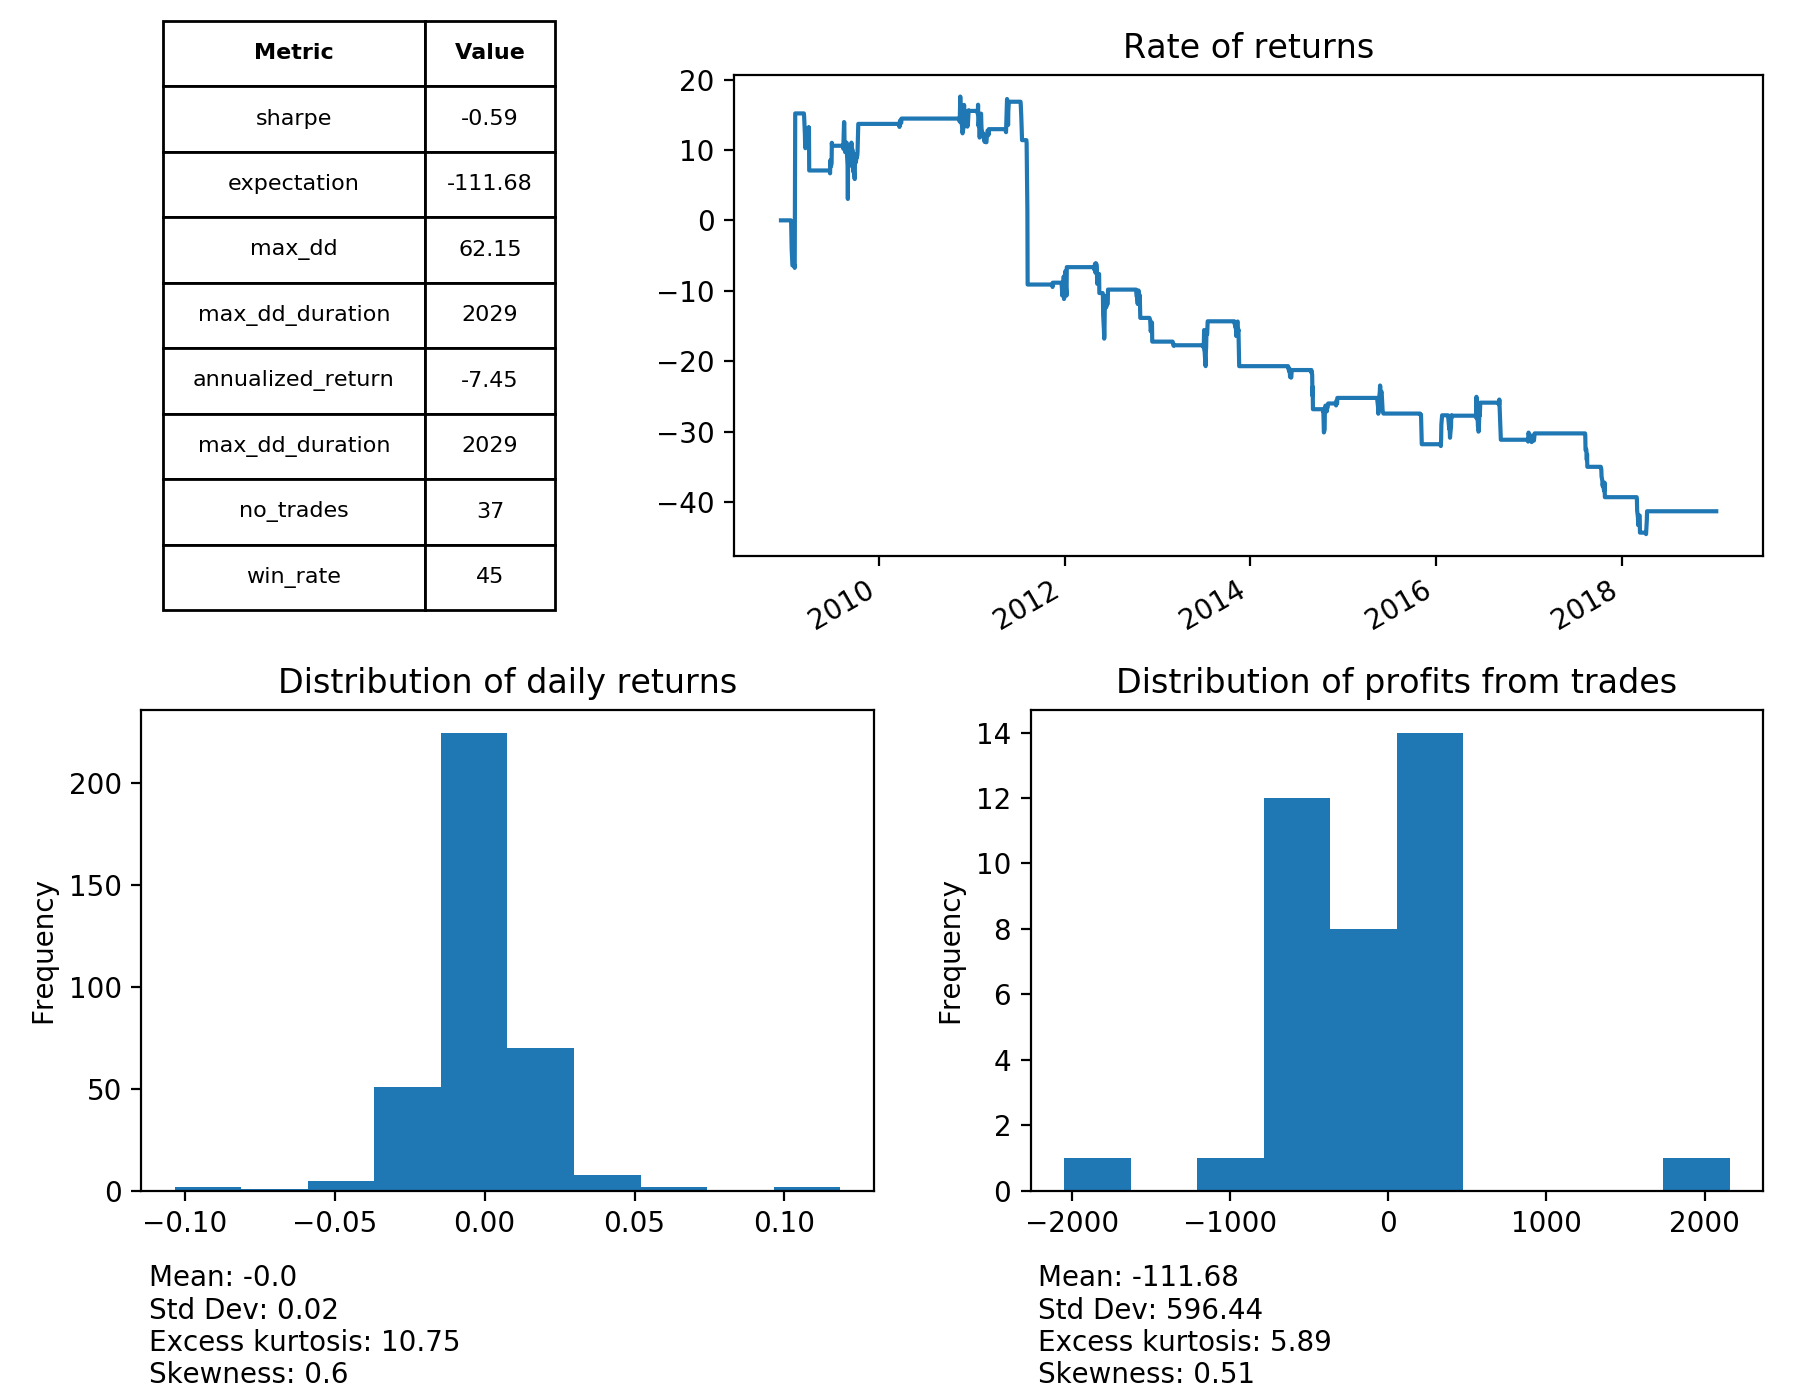

In [47]:
df_with_signals2 = generate_signals_2(
    symbol_data,
    ma_type='simple',
    time_window=20,
    no_std=2,
    min_holding_period=5,
    perc_to_region = 0.4
)
tester2 = backtester.Backtester({symbol_key: df_with_signals2['df']}, position_sizer=position_sizer, )
tester2_results, tester2_trades = tester2.run()
results.performance_report(tester2_results, tester2_trades)

- Still strategy is loosing in the long run. As previously there is one biggest loss (~30%) and the sequence of small losses.
- There is slightly better sharpe ratio and two more trades.
- The only much better thing is 45% of win-rate. It makes all the losses slightly smaller - but still is not able to encompensate for all the losses.
- Strategy is still flaky. I believe that the reason is not enough entry signals. Setup and entry behaves like it waits for the big move to catch up on trend. In other circumstances (shorter swings) it does not perform. From the other hand it tries to behave a little bit like swing strategy (long/short on bollinger bands where price is shortly overbought/oversold).

In [ ]:
"""
Next steps:
- will skip trying to figure out reward-to-risk-ratio here
- crate pipeline which will optimize the strategy parameters
- summarize optimization process (which parameters are the best and how variability changes)
- choose params and and more symbols and risk component
""";